In [205]:
import geopandas as gpd
import shapely
from shapely.geometry import Point

import pandas as pd
import numpy as np
import pickle
from datetime import datetime, date, time

from fbprophet import Prophet

import matplotlib.pylab as plt
plt.style.use('ggplot')
%matplotlib inline

In [200]:
ll_crs = {'init': 'epsg:4326'}

### EIA region shapefile preprocessing

In [201]:
# power region geo boundaries (data provided by EIA)
region_shp = gpd.read_file('data/ElectricSytemOperatingRegions_EIA-shape files/EIA930_Regions_20160506_WGS84.shx')

In [202]:
region_shp.drop(['Shape_Area', 'Shape_Leng'], axis=1, inplace=True)
region_shp = region_shp.to_crs(ll_crs)

In [203]:
def union_parts(multi):
    """
    - adds a buffer to all sub-polygons to eliminate faulty edges
    - reduces number of sub-polygons by performing a cascading union, where possible
    """
    if type(multi) == shapely.geometry.multipolygon.MultiPolygon:
        allparts = [part.buffer(0) for part in multi]
        unioned = shapely.ops.cascaded_union(allparts)
        return unioned
    else:
        return multi

In [206]:
# touch up invalid polygons (bad self intersections)
region_shp.loc[:, 'geometry'] = map(union_parts, region_shp.loc[:, 'geometry'])

In [207]:
region_shp.head()

,EIA_Region,geometry
0,California,(POLYGON ((-114.2997240000745 34.1588979998338...
1,Carolinas,(POLYGON ((-77.94237900003289 36.5445129996888...
2,Central,(POLYGON ((-102.5477049998308 46.2827879998399...
3,Florida,(POLYGON ((-82.11678699982296 24.5491439996071...
4,Mid Atlantic,(POLYGON ((-84.82944799969027 38.8971309999546...


In [216]:
# write region shapes to file
with open('./data/region_shapes.pickle', 'wb') as handle:
    pickle.dump(region_shp, handle, protocol=pickle.HIGHEST_PROTOCOL)

### cities preprocessing

In [208]:
with open('./data/cities.pickle', 'rb') as handle:
    cities = pickle.load(handle)

In [209]:
def switch_latlng(point):
    """
    swaps lat of for long
    googlemaps API and shapely API coordinate sysems are opposite
    """
    x = point.y
    y = point.x
    return Point(x, y)

In [210]:
# set geom with geopandas, switch lat/lng
cities  = gpd.GeoDataFrame(cities, crs=ll_crs, geometry='location')
cities['fg'] = map(switch_latlng, cities.loc[:, 'location'])
cities.drop('location', axis=1, inplace=True)
# rename geom column
cities.columns = [u'city', u'state', u'state_abb', u'population', u'USAF',
       u'WBAN', u'geometry']

In [211]:
cities.head()

,city,state,state_abb,population,USAF,WBAN,geometry
0,New York,New York,NY,8550405,997271,99999,POINT (-74.0059413 40.7127837)
1,Los Angeles,California,CA,3971883,722874,93134,POINT (-118.2436849 34.0522342)
2,Chicago,Illinois,IL,2720546,998499,99999,POINT (-87.6297982 41.8781136)
3,Houston,Texas,TX,2296224,720594,188,POINT (-95.3698028 29.7604267)
4,Philadelphia,Pennsylvania,PA,1567442,724080,13739,POINT (-75.1652215 39.9525839)


### aggregating weather to EIA regions

In [212]:
# locate cities within regional boundaries with a spatial join
cities_located = gpd.sjoin(cities, region_shp, how="inner", op='within')

In [217]:
cities_located.head()

,city,state,state_abb,population,USAF,WBAN,geometry,index_right,EIA_Region
208,Thousand Oaks,California,CA,129339,723926,23136,POINT (-118.8375937 34.1705609),0,California
281,Burbank,California,CA,105319,722880,23152,POINT (-118.3089661 34.1808392),0,California
107,Oxnard,California,CA,207254,723927,93110,POINT (-119.1770516 34.1975048),0,California
519,Camarillo,California,CA,67608,723926,23136,POINT (-119.0376023 34.2163937),0,California
216,Simi Valley,California,CA,126788,722886,23130,POINT (-118.781482 34.2694474),0,California


In [214]:
# how many cities in each region?
for i, group in cities_located.groupby('EIA_Region'):
    print i, len(group)

California 177
Carolinas 24
Central 39
Florida 55
Mid Atlantic 88
Midwest 110
New England 41
New York 12
Northwest 82
Southern 25
Southwest 25
TVA 15
Texas 58


In [218]:
# write region-located city information to file
with open('./data/region_cities.pickle', 'wb') as handle:
    pickle.dump(cities_located.loc[:, ['city', 'state', 'state_abb', 'EIA_Region']],\
                handle, protocol=pickle.HIGHEST_PROTOCOL)

In [346]:
# read in the weather time series data for all US cities
with open('./data/weather_series.pickle', 'rb') as handle:
    weather = pickle.load(handle)

In [347]:
def weighted_avg(row, city_pops):
"""
computes the population-weighted avg of temperature for a set of cities
(given that all cities are in single df row for a given time stamp)
ignores NaN values and NaN-equivalent values in calculation
"""
    def exists(num):
        # the 'missing value' representation from NOAA is (+/-) 9999 
        if (num > 100) or (num < -100) or (np.isnan(num)):
            return False
        else:
            return True
    
    indices = np.where(map(exists, row))[0]
    # weighted average, using a mask array that filters out missing values
    return np.average(row[indices], weights=np.array(city_pops)[indices])

In [423]:
def date_maker(row):
    """
    generates datetime object from a dataframe row
    """
    return datetime(row['year'], row['month'], row['day'], row['hour'])

In [ ]:
# use a consistent index object for all regional weather time series
master_index = pd.date_range('2015-01-01 01:00:00', '2017-05-03 05:00:00', freq="1H")

### weighted average algorithm

In [349]:
# finally, compute population weighted averages for each EIA power region
region_weather_dict = {}

# iterate through each EIA region of member-cities
for region, cities in cities_located.groupby('EIA_Region'):
    print 'REGION: {}'.format(region)
    cities.reset_index(drop=True, inplace=True)
    # get population for entire region (all member cities)
    region_pop = cities.population.sum()
    # also need an array of city populations to use in the weighted avg
    city_pops = []
    # initiate a dataframe at the region level
    region_weather = pd.DataFrame(index=master_index)
    # iterate through each city in the region
    for i, city in cities.iterrows():
        city_pops.append(city['population'])
        city_index = city['city'] + ', ' + city['state_abb']
        print '{} of {}: {}'.format(i, len(cities), city_index)
        # pull in the weather series for the given city
        city_weather = weather[city_index]
        city_weather['date_index'] = city_weather.apply(date_maker, axis=1)
        city_weather.set_index('date_index', drop=True, inplace=True)
        city_weather.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)
        # note: NOAA provides temperatures at 10X scale; remove this
        city_weather.loc[:, 'temp'] = city_weather.loc[:, 'temp'] / 10.0
        city_weather.columns = [city['city'] + '_temp']
        # merge with region-level dataframe on datetime index
        region_weather = region_weather.merge(city_weather, how='left', left_index=True, right_index=True)
    # population-weighted mean for temperature, across rows for each timestamp
    avg_weather = region_weather.apply(lambda row: weighted_avg(row, city_pops), axis=1)
    region_weather_dict[region] = avg_weather


REGION: California
0 of 177: Thousand Oaks, CA
1 of 177: Burbank, CA
2 of 177: Oxnard, CA
3 of 177: Camarillo, CA
4 of 177: Simi Valley, CA
5 of 177: San Buenaventura, CA
6 of 177: Santa Clarita, CA
7 of 177: Santa Barbara, CA
8 of 177: Palmdale, CA
9 of 177: Lancaster, CA
10 of 177: Santa Maria, CA
11 of 177: Bakersfield, CA
12 of 177: Porterville, CA
13 of 177: Tulare, CA
14 of 177: Hanford, CA
15 of 177: Visalia, CA
16 of 177: Fresno, CA
17 of 177: Clovis, CA
18 of 177: Madera, CA
19 of 177: Merced, CA
20 of 177: Turlock, CA
21 of 177: Modesto, CA
22 of 177: Tracy, CA
23 of 177: Manteca, CA
24 of 177: Stockton, CA
25 of 177: Lodi, CA
26 of 177: Elk Grove, CA
27 of 177: Sacramento, CA
28 of 177: Rancho Cordova, CA
29 of 177: Folsom, CA
30 of 177: Citrus Heights, CA
31 of 177: Roseville, CA
32 of 177: Rocklin, CA
33 of 177: Gilroy, CA
34 of 177: Delano, CA
35 of 177: West Sacramento, CA
36 of 177: San Clemente, CA
37 of 177: Laguna Niguel, CA
38 of 177: Mission Viejo, CA
39 of 177: Ne

In [350]:
with open('./data/region_weather.pickle', 'wb') as handle:
    pickle.dump(region_weather_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
# aggregate regional weather to the daily level,
# capturing both daily highs (for cooling demand in summer)
# and daily lows (for heating demand in winter)
regional_highs = {}
regional_lows = {}

for key in region_weather_dict.keys():
    regional_highs[key] = region_weather_dict[key].resample('1D').max()
    regional_lows[key] = region_weather_dict[key].resample('1D').min()

In [36]:
# write highs and lows to file
with open('./data/region_highs.pickle', 'wb') as handle:
    pickle.dump(regional_highs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/region_lows.pickle', 'wb') as handle:
    pickle.dump(regional_lows, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('./data/region_highs.pickle', 'rb') as handle:
    regional_highs = pickle.load(handle)

with open('./data/region_lows.pickle', 'rb') as handle:
    regional_lows = pickle.load(handle)

### cleaning up the power demand data

In [23]:
with open('./data/power_series.pickle', 'rb') as handle:
    demand = pickle.load(handle)

In [24]:
# rename demand dict keys
demand['Mid Atlantic'] = demand.pop('Demand for Mid-Atlantic (region), Hourly')
demand['TVA'] = demand.pop('Demand for Tennessee Valley Authority (TVA), Hourly')
demand['Southwest'] = demand.pop('Demand for Southwest (region), Hourly')
demand['California'] = demand.pop('Demand for California (region), Hourly')
demand['Texas'] = demand.pop('Demand for Electric Reliability Council of Texas, Inc. (ERCO), Hourly')
demand['Florida'] = demand.pop('Demand for Florida (region), Hourly')
demand['New York'] = demand.pop('Demand for New York Independent System Operator (NYIS), Hourly')
demand['Northwest'] = demand.pop('Demand for Northwest (region), Hourly')
demand['Midwest'] = demand.pop('Demand for Midwest (region), Hourly')
demand['Central'] = demand.pop('Demand for Central (region), Hourly')
demand['Southern'] = demand.pop('Demand for Southeast (region), Hourly')
demand['New England'] = demand.pop('Demand for New England ISO (ISNE), Hourly')
demand['Carolinas'] = demand.pop('Demand for Carolinas (region), Hourly')

In [25]:
# convert demand time series timestamps to real timestamps for use in axis
def str_to_time(stamp):
    """
    converts a timestamp string into proper datetime object
    """
    yr = int(stamp[:4])
    mth = int(stamp[4:6])
    day = int(stamp[6:8])
    hr = int(stamp[9:11])
    return datetime(yr, mth, day, hr)

In [26]:
def list_to_series(demand_list):
    """
    converts the 'list of list' format given by EIA API into a regular indexed time series
    """
    ser =  pd.Series(map(lambda datapoint: datapoint[1], demand_list),
                     index=map(lambda datapoint: str_to_time(datapoint[0]), demand_list))
    # resample to daily level
    return ser.resample('1D').sum()

In [89]:
for key in demand.keys():
    # we have an extra two days of data on the demand series; truncate it
    demand[key] = list_to_series(demand[key])[:-2]

In [32]:
demand['Central'].head()

2015-07-01    796723
2015-07-02    774333
2015-07-03    691318
2015-07-04    669451
2015-07-05    693343
Freq: D, dtype: int64

In [90]:
# rewrite the clean demand data
with open('./data/demand.pickle', 'wb') as handle:
    pickle.dump(demand, handle, protocol=pickle.HIGHEST_PROTOCOL)

## weather & periodicity normalization

In [180]:
with open('./data/region_highs.pickle', 'rb') as handle:
    regional_highs = pickle.load(handle)

with open('./data/region_lows.pickle', 'rb') as handle:
    regional_lows = pickle.load(handle)
    
with open('./data/demand.pickle', 'rb') as handle:
    demand = pickle.load(handle)

### problemo:
note that for more robust weather normalization (that would be more sensitive to long stints of hot or cold), we'd want to compare observed temps against historical averages for each region. as it is, we're just comparing against itself looking for "local extremes" on moving averages. we're sensitive to initial changes in weather, but if the heat wave lastsa for a few weeks, the sensititivty gets worse... maybe that's ok? dunno. the perfect method would be to first normalize weather against historical averages, and then to remove seasonality.

### weather normalization

In [ ]:
for region in demand.keys():
    
    highs = regional_highs[region]
    lows = regional_highs[region]
    rolling_highs = regional_highs[region].rolling(window=14).mean()
    rolling_lows = regional_highs[region].rolling(window=14).mean()
    
    for day in demand[region].index:
        # adjustment for cooling loads (summer months)
        if day.month in [5, 6, 7, 8, 9]:
            # check if day's temp is higher than the rolling avg
            percent_over = (highs[day] - rolling_highs[day]) / abs(rolling_highs[day])
            if percent_over > 0:
                # normalize heating demand downwards; 50% weight
                print 'log: summer', region, day.date(), round(highs[day], 1), round(percent_over * 100, 1)
                demand[region][day] = demand[region][day] - \
                (percent_over * 0.6 * demand[region][day]) # 60% weight
        # adjustment for heating loads
        elif day.month in [11, 12, 1, 2, 3]:
            percent_under = (rolling_lows[day] - lows[day]) / abs(rolling_lows[day])
            # check if day's temp is lower than the rolling avg
            if percent_under > 0:
                # normalize cooling demand downwards; 25% weight
                print 'log: winter', region, day.date(), round(lows[day], 1), round(percent_under * 100, 1)
                demand[region][day] = demand[region][day] - \
                (percent_under * 0.4 * demand[region][day]) # 40% weight
        # this leaves two shoulder months that we dont adjust for
        else:
            pass

### removing periodicity

In [182]:
for region in demand.keys():

    df = pd.DataFrame(demand[region], columns=['actual'])
    df['y'] = np.log(df.loc[:, 'actual'])
    df['ds'] = df.index
    
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    m.fit(df)
    modelled = m.predict(df)
    modelled['norm'] = modelled.actual - np.exp(modelled.yhat)
    modelled.set_index('ds', drop=True, inplace=True)
    
    demand[region] = modelled.loc[:, ['actual', 'norm']]

/Users/ian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


### isolating anomalies

In [195]:
# build a list of anomalies
anoms = []
for region in demand.keys():
    df = demand[region]
    std = np.std(demand[region]['norm'])
    mean = np.mean(demand[region]['norm'])
    
    # we're specifically interested in demand PEAKS, not unusual dips
    # so we'll only isolate the abnormally high 
    regional_anoms = df[df.norm > (mean + 2*std)].index
    for day in regional_anoms:
        anoms.append((region, day))

In [198]:
# rewrite the clean demand data
with open('./data/anoms.pickle', 'wb') as handle:
    pickle.dump(anoms, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [267]:
#anoms

In [ ]:
# write anomalies to file
with open('./data/demand.pickle', 'wb') as handle:
    pickle.dump(demand, handle, protocol=pickle.HIGHEST_PROTOCOL)

## PLOTS FOR PAPER

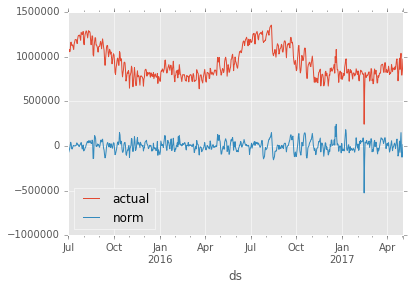

In [256]:
demand['Texas'].plot()

In [220]:
with open('./data/region_weather.pickle', 'rb') as handle:
    regional_weather = pickle.load(handle)

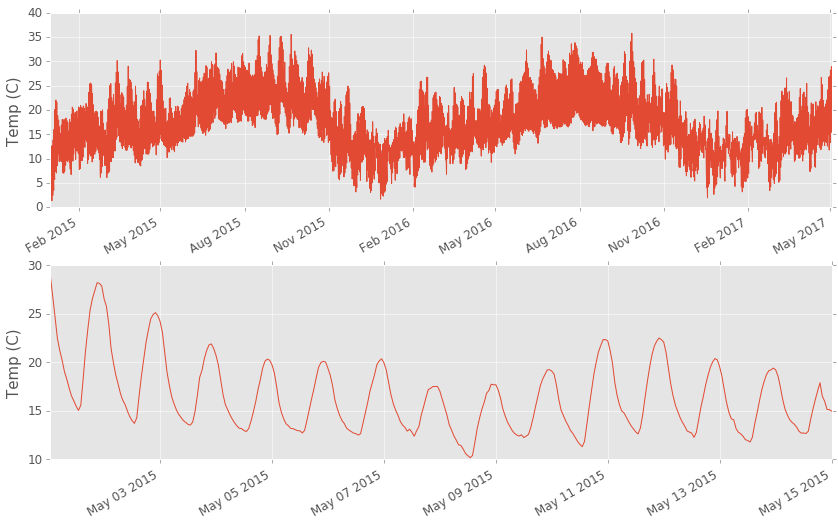

In [251]:
fig, axs = plt.subplots(2)
fig.set_size_inches(14,8)
fig.subplots_adjust(hspace=0.3)
axs[0].plot(regional_weather['California'])
axs[1].plot(regional_weather['California'][2880:3216])

axs[0].set_ylabel('Temp (C)', size=15)
axs[1].set_ylabel('Temp (C)', size=15)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)

for label in axs[0].get_xmajorticklabels() + axs[1].get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")

In [261]:
std = np.std(demand['Texas']['norm'])
mean = np.mean(demand['Texas']['norm'])
std_line  = mean + 2*std

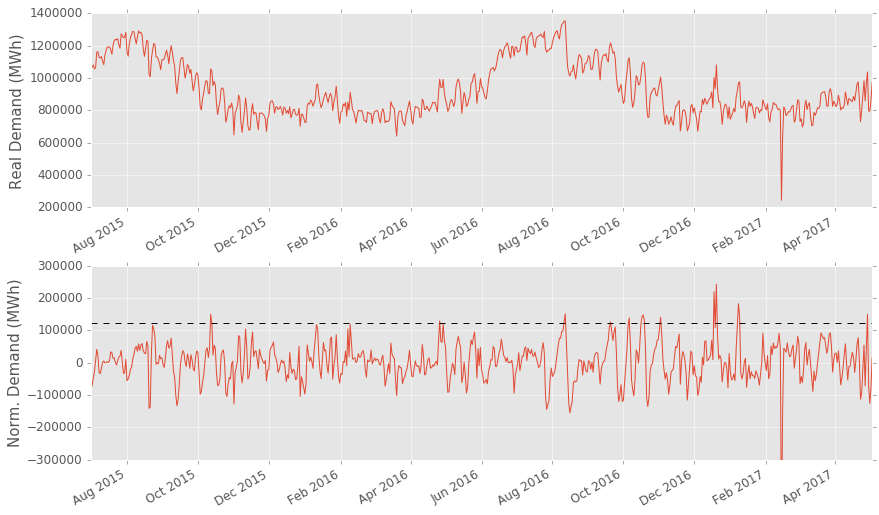

In [266]:
fig, axs = plt.subplots(2)
fig.set_size_inches(14,8)
fig.subplots_adjust(hspace=0.3)
axs[0].plot(demand['Texas']['actual'])
axs[1].plot(demand['Texas']['norm'])
axs[1].axhline(y=std_line, color='k', linestyle='--')

axs[0].set_ylabel('Real Demand (MWh)', size=15)
axs[1].set_ylabel('Norm. Demand (MWh)', size=15)
axs[1].set_ylim([-300000,300000])
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)


for label in axs[0].get_xmajorticklabels() + axs[1].get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")